## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import *

import warnings
#warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
# code from exercise 5 to calculate the z-score
z_score = lambda x : (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def conf_mat(y_hat, y_true):
    '''Returns a confusion matrix'''
    n = max(y_hat)+1
    bingo = np.zeros([n,n])
    for i in range(len(y_hat)):
        bingo[y_true[i]][y_hat[i]] +=1
    
    return(bingo)

def scores(y_hat, y_true, average = True):
    '''For each class, returns recall, precision and f1'''
    classes = list(np.unique(y_true))
    conf = conf_mat(y_hat, y_true)
    r = []
    p = []
    f = []
    for c in classes:
        recall = conf[c][c] / sum(conf[c])
        precision = conf[c][c] / sum(conf[:, c])
        f1 = 2*(precision*recall)/(precision + recall)
        r.append(recall)
        p.append(precision)
        f.append(f1)
    if average:
        return sum(r)/len(r), sum(p)/len(p), sum(f)/len(f)
    else:
        return (r, p, f)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    Function copied from exercise 7.
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Variables and df loading

In [4]:
col = 'rainbow' # Colour theme

df = pd.read_csv(TRAIN) # Training dataframe
a = len(df)

#ensures data is without order, random state fixed for reproducability, frac=1 gives the whole df back but shuffled
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

if a != len(df):
    print('WARNING, DATA IS BEING LOST')#confirm still have the whole df

attributes = list(df.columns)[:-1] # Creates list of column names for the dataframe without the class

df[attributes] = z_score(df[attributes])

X = df[attributes].copy() # Attributes
y = df['type'].copy() # True values

for i in range(len(y)):
    if y[i] > 4:
        y[i] = y[i] - 2
    else:
        y[i] = y[i] - 1
        
lb = preprocessing.LabelBinarizer()
new_y = pd.DataFrame(lb.fit_transform(y))

y_list = y.unique() # 'y' values

#round(df.describe(),2)
df['type'] = y
df[[0,1,2,3,4,5]] = new_y

df.head(10)
round(df[attributes].describe(),2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,149.00,149.00,149.00,149.00,149.00,149.00,149.00,149.00,149.00
mean,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.27,-3.13,-1.92,-2.27,-3.61,-0.85,-2.32,-0.36,-0.63
25%,-0.56,-0.57,-0.31,-0.52,-0.44,-0.63,-0.47,-0.36,-0.63
50%,-0.23,-0.14,0.54,-0.15,0.20,0.11,-0.22,-0.36,-0.63
75%,0.23,0.48,0.62,0.37,0.55,0.22,0.14,-0.36,0.50
max,4.84,4.60,0.89,4.09,3.57,10.08,4.82,5.35,3.17


Using ideas from:

https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

https://hackernoon.com/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b

https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

In [16]:
class NeuralNetwork:
    
    def __init__(self, x, y, neurons=12, lr=0.01):
        '''
        neurons --> neurons per hidden layer
        activation --> choose activation function
        '''
        
        self.input = x # All rows with the attributes (all X's)
        #self.y = np.array(y) # True values
        self.labels = y # true labels
        self.rows = x.shape[0] # number of rows
        self.class_count = len(y.unique()) # number of classes
        self.y = np.zeros((self.rows, self.class_count)) # one hot labels
        for i in range(self.rows):
            self.y[i, self.labels[i]] = 1
        
        self.output = np.zeros(self.y.shape) #
        
        self.neurons = neurons # number of neurons per label
        np.random.seed(23)
        
        self.weight1 = np.random.rand(x.shape[1], neurons) # (attributes in X, number of neurons)
        #self.weight2 = np.random.rand(neurons, neurons)
        self.weight_final = np.random.rand(neurons, self.y.shape[1])

        self.bias1 = np.random.randn(neurons)
        #self.bias2 = bias[1]
        self.bias_final = np.random.randn(self.class_count)
        
        self.lr = lr
        self.error_cost = []
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def relu(self): # Rectified Linear Unit
        return np.maximum(0, self.x)
    
    def softmax(self, x):
        exp = np.exp(x.to_numpy())
        probabilities = exp / np.sum(exp,axis=1, keepdims=True)
        return probabilities 
    
    def sigmoid_der(self, x):
        """Code borrowed from:
        https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
        """
        return self.sigmoid(x) * (1 - self.sigmoid(x))
   
    def tanh_der(self, x):
        return 1 - (self.tanh(x)**2)

    def forwardpass(self, x):
    
        # 1st layer with Activation Function
        self.layer1 = self.sigmoid((x.dot(self.weight1) + self.bias1))
        #self.layer1 = self.tanh((x.dot(self.weight1) + self.bias1))
        
        #self.layer2 = self.sigmoid(self.layer1.dot(self.weight2) + self.bias2)
        #print(self.layer2.shape)
        
        # Final Output layer with softmax
        self.output = self.softmax(self.layer1.dot(self.weight_final) + self.bias_final)
        
        return self.output

    def categorical_cross_entropy(self, X):
        '''Function to calculate categorical cross entropy
        WE DON'T USE THIS, RIGHT???
        '''
        p = self.output # predictions
        sum_score = 0.0
        for i in range(len(self.y)):
            for j in range(len(self.y[i])):
                sum_score += self.y[i][j] * np.log(1e-15 + p[i][j])
        mean_sum_score = 1.0 / len(self.y) * sum_score
        return -mean_sum_score
    
    def backprop(self):
        """Back Propogation!!!!
        """
        difference = self.output - self.y # Difference between forward output and true labels
        weight_cost = np.dot(self.layer1.T, difference)
        bias_cost = difference
        
        #dcost = np.dot(difference, weight_cost.T) we don't seem to use this
        backwards_sig = self.sigmoid_der((np.dot(self.input, self.weight1) + self.bias1))
        #backwards_tanh = self.tanh_der((np.dot(self.input, self.weight1) + self.bias1))
        
        back_cost_w = np.dot(self.input.T, backwards_sig * np.dot(difference, weight_cost.T))
        back_cost_b = np.dot(difference, weight_cost.T) * backwards_sig
        
        #back_cost_w = np.dot(self.input.T, backwards_tanh * np.dot(difference, weight_cost.T))
        #back_cost_b = np.dot(difference, weight_cost.T) * backwards_tanh
        
        # Update weights and biases using learning rate
        self.weight1 -= self.lr * back_cost_w
        self.bias1 -= self.lr * back_cost_b.sum(axis=0)
        
        self.weight_final -= self.lr * weight_cost
        self.bias_final -= self.lr * bias_cost.sum(axis=0)
        
        loss = np.sum(-self.y * np.log(self.output)) # categorical cross entropy
        
        return loss
        
    def train(self, X, y):
        """Function that updates the output to the result of the forward pass, and 
        appends the error cost after backpropogation.
        """
        self.output = self.forwardpass(X)
        self.error_cost.append(self.backprop())

In [17]:
# Initialize the biases
bias=np.array([0]*3)

# Build the Neural Network
kitty = NeuralNetwork(X, y)

#kitty.forwardpass(X)
#kitty.backprop()

# Train for 1000 epochs
for i in range(1000):
    kitty.train(X, new_y)
    
print(f'Sum of all values for first record: {sum(kitty.output[0])} \
    \nFirst row label guesses: {kitty.output[0]} \
    \nPredicted Class: {np.argmax(kitty.output[0])} \
    \nTrue Class: {y[0]}')

Sum of all values for first record: 1.0     
First row label guesses: [0.00253873 0.64277568 0.00421305 0.14334223 0.06780808 0.13932223]     
Predicted Class: 1     
True Class: 1


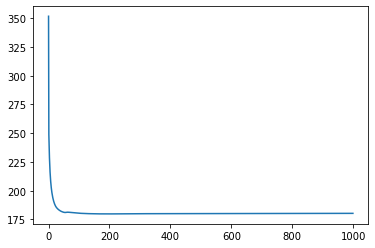

In [18]:
plt.plot(kitty.error_cost)
plt.show()

In [8]:
one_hot_y = np.zeros((X.shape[0], len(y.unique()))) # one hot labels
for i in range(X.shape[0]):
    one_hot_y[i, y[i]] = 1

print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = kitty.output
print('log_loss:   ', log_loss(one_hot_y, y_pred, eps=1e-15))

y_true = one_hot_y.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean(), '\n')

target_names = ['class {}'.format(i+1) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names,zero_division=0)) # Set 0 division to 0 as default

# Print Confusion matrix
confu = confusion_matrix(y_true, y_pred)
confu


 ########## Result for Test Data ########## 

log_loss:    1.2103304849126966
accuracy:    0.4697986577181208 

              precision    recall  f1-score   support

     class 1       0.42      1.00      0.59        49
     class 2       0.43      0.11      0.18        53
     class 3       0.00      0.00      0.00        12
     class 4       0.00      0.00      0.00         9
     class 5       0.00      0.00      0.00         6
     class 6       0.94      0.75      0.83        20

    accuracy                           0.47       149
   macro avg       0.30      0.31      0.27       149
weighted avg       0.41      0.47      0.37       149



array([[49,  0,  0,  0,  0,  0],
       [46,  6,  0,  1,  0,  0],
       [12,  0,  0,  0,  0,  0],
       [ 3,  5,  0,  0,  0,  1],
       [ 4,  2,  0,  0,  0,  0],
       [ 4,  1,  0,  0,  0, 15]], dtype=int64)

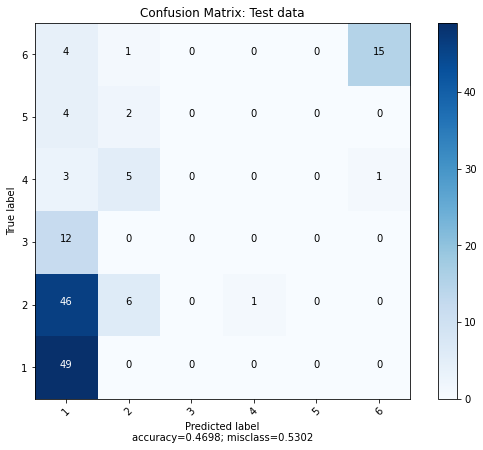

In [9]:
plot_confusion_matrix(cm           = confu, 
                      normalize    = False,
                      target_names = ['1', '2', '3', '4', '5', '6'],
                      title        = "Confusion Matrix: Test data")

In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

instances = X.shape[0]
attributes = X.shape[1]
hidden_nodes = 4
output_labels = 6

weight1 = np.random.rand(attributes, hidden_nodes)
bias1 = np.random.randn(hidden_nodes)

weight_final = np.random.rand(hidden_nodes, output_labels)
bias_final = np.random.randn(output_labels)
learning_rate = 0.01

one_hot_labels = np.zeros((149, 6))
for i in range(149):
    one_hot_labels[i, y[i]] = 1

error_cost = []

for epoch in range(1000):
############# feedforward

    # Phase 1
    layer1 = sigmoid(np.dot(X, weight1) + bias1)

    # Phase 2
    output = softmax(np.dot(layer1, weight_final) + bias_final)

########## Back Propagation
########## Phase 1

    difference = output - one_hot_labels

    weight_cost = np.dot(layer1.T, difference)

    bias_cost = difference

########## Phases 2

    #dcost_dah = np.dot(difference , weight_cost.T)
    dah_dzh = sigmoid_der(np.dot(X, weight1) + bias1)
    
    dcost_wh = np.dot(X.T, sigmoid_der(np.dot(X, weight1) + bias1) * np.dot(difference , weight_cost.T))
    dcost_bh = np.dot(difference , weight_cost.T) * sigmoid_der(np.dot(X, weight1) + bias1)

    # Update Weights ================

    weight1 -= learning_rate * dcost_wh
    bias1 -= learning_rate * dcost_bh.sum(axis=0)

    weight_final -= learning_rate * weight_cost
    bias_final -= learning_rate * bias_cost.sum(axis=0)

    loss = np.sum(-one_hot_labels * np.log(output))
    #print('Loss function value: ', loss)
    error_cost.append(loss)

223.17010025198522

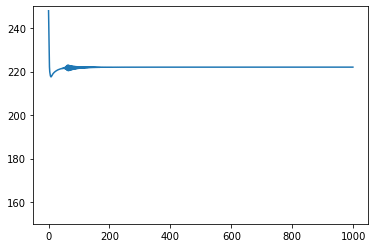

In [11]:
plt.plot(error_cost)
plt.ylim(150,250);